In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
class Phase():
    name:str
    predictors:list
    number_of_trial:int
    outcome:bool
    total_learning:float
    total_learning_history:list


class Predictor():
    def __init__(self,name, alpha):
        self.name = name
        self.alpha = alpha
        self.associative_strength = {}


class Group():
    def __init__(self, name):
        self.name = name
        self.phases = []

    def add_phase_for_group(self,phase_name:str, predictors:list, number_of_trial:int,outcome:bool):
        phase = Phase()
        phase.name = phase_name
        phase.number_of_trial = number_of_trial
        phase.outcome = outcome
        phase.predictors = predictors
        phase.total_learning = 0
        phase.total_learning_history = []
        self.phases.append(phase)

class Model_Rescorla_Wager():
    def __init__(self, lambda_US=1, beta_US=0.05):
        self.groups = []
        self.predictor_learning_for_phase = {}
        self.result = pd.DataFrame(columns=['group', 'phase', 'predictor','associative_strength','Predictors by Phase','trial'])
        self.lambda_US = lambda_US
        self.beta_US = beta_US
    def add_group(self, group:Group):
        self.groups.append(group)    

    def model_run(self):
        index = 0
        
        for group in self.groups:
            phase_index=0
            lambda_US = 0
            for phase in group.phases:
                # if the outcome is presented then the lambda is set otherwise it is 0.
                if phase.outcome: 
                    lambda_US = self.lambda_US
                phase_index+=1
                # check previous phases about the predictor learning
                for i in range(1,phase.number_of_trial+1):
                    
                    # trial total learning of all predictors for the current trail
                    phase.total_learning = 0 
                    for predictor in phase.predictors:
                        # data reference in the python dictiory with group name + precdictor name + phase index
                        index_key = str(group.name)+'_'+str(predictor.name)+'_' + str(phase_index)
                        index_key_prev = str(group.name)+'_'+str(predictor.name)+'_' + str(phase_index - 1)
                        
                        # if the there is any predictor already calculated.
                        if (index_key) in predictor.associative_strength.keys():
                            phase.total_learning = phase.total_learning + predictor.associative_strength[index_key][str(i)]
                        
                        # if there is any phase for this predictor before , it is already associated, lets add the prev phase association to the learning
                        if (index_key_prev) in predictor.associative_strength.keys() and phase_index > 1 and i==1:
                            phase.total_learning =   phase.total_learning  + predictor.associative_strength[index_key_prev][str(phase.number_of_trial+1)]  

                        # maximum learning reached!
                        if phase.total_learning > self.lambda_US:
                            phase.total_learning = self.lambda_US

                        phase.total_learning_history.append(phase.total_learning)


                    for predictor in phase.predictors:
                        # data reference in the python dictiory with group name + precdictor name + phase index
                        index_key = str(group.name)+'_'+str(predictor.name)+'_'+str(phase_index)
                        index_key_prev = str(group.name)+'_'+str(predictor.name)+'_' + str(phase_index - 1)
                        
                        if i == 1:
                            predictor.associative_strength[index_key] = {}
                            if (index_key_prev) in predictor.associative_strength.keys():
                                predictor.associative_strength[index_key][str(i)] = predictor.associative_strength[index_key_prev][str(phase.number_of_trial+1)]  
                            else:
                                predictor.associative_strength[index_key][str(i)] = 0.0
                            self.result.loc[index] = [group.name, phase.name, predictor.name,predictor.associative_strength[index_key][str(i)],str(group.name) + '-' + str(predictor.name), i ]
                            index += 1


                        #print(index_key , phase.total_learning)    
                        predictor.associative_strength[index_key][str(i+1)] =  predictor.associative_strength[index_key][str(i)] + predictor.alpha * self.beta_US * (lambda_US -  phase.total_learning )
                        #print(index_key, predictor.associative_strength[index_key][str(i+1)])
                        self.result.loc[index] = [group.name, phase.name, predictor.name,predictor.associative_strength[index_key][str(i+1)],str(group.name) + '-' + str(predictor.name), i+1 ]
                        index += 1
                        
    def display_results(self):
        #pd.set_option('display.max_rows', 100)
        self.result.head()
        #plt.autoscale(enable=False, axis='both')
        sns.set_style("whitegrid", {'grid.linestyle': '--'})
        fig, axes = plt.subplots(1, len(self.result['phase'].unique()), figsize=(24, 6), sharey=True)
        fig.suptitle('Model Results',weight='bold')
        i = 0 
        plt.xticks = 1
        for phase in self.result['phase'].unique():
            sns.lineplot(ax=axes[i],  x="trial", hue = 'Predictors by Phase', y="associative_strength", marker='o',
                                    data=self.result[self.result['phase'] == phase ][['trial','associative_strength','Predictors by Phase']])
            axes[i].set_title(phase,weight='bold')
            axes[i].xaxis.set_major_locator(plt.MaxNLocator(11))
            i +=1
        plt.show()  

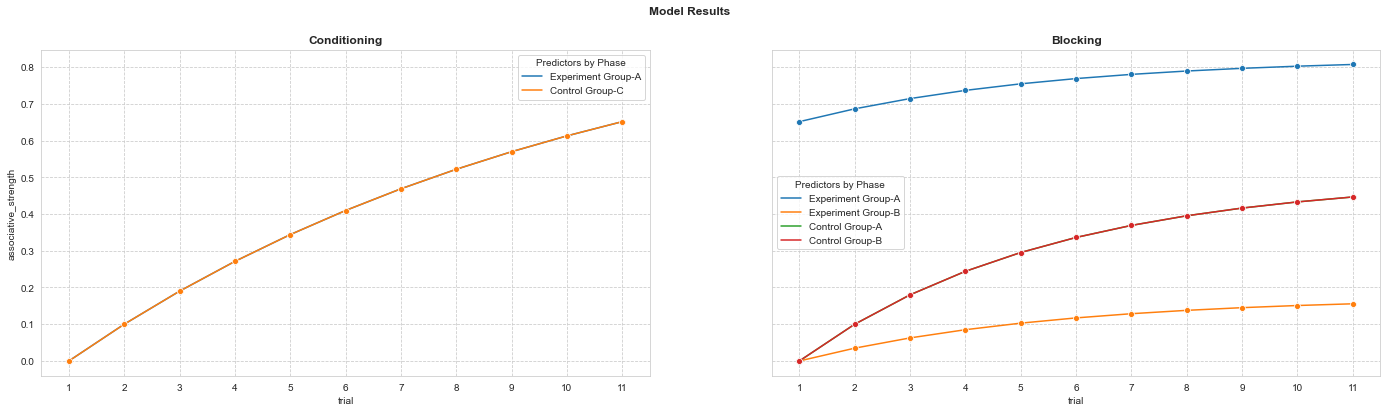

In [8]:
# Define the model
experiment = Model_Rescorla_Wager(lambda_US=1, beta_US=0.5)

# Define the predictors
A = Predictor(name='A', alpha = 0.2)
B = Predictor(name='B',alpha = 0.2)
C = Predictor(name='C',alpha = 0.2)

# Define the experiment groups
experiment_group = Group(name="Experiment Group")
experiment_group.add_phase_for_group(phase_name='Conditioning', predictors=[A], outcome=True, number_of_trial=10)
experiment_group.add_phase_for_group(phase_name='Blocking', predictors=[A,B], outcome=True, number_of_trial=10)
experiment.add_group(experiment_group)

control_group = Group(name="Control Group")
control_group.add_phase_for_group(phase_name='Conditioning', predictors=[C], outcome=True, number_of_trial=10)
control_group.add_phase_for_group(phase_name='Blocking', predictors=[A,B], outcome=True, number_of_trial=10)
experiment.add_group(control_group)

# Run the model
experiment.model_run()
experiment.display_results()
